# Custom Vision vs Own Model for object detection

### Cel : 
Celem naszego projektu jest wytrenewanie, zapoznanie się z modelami dla wykrywanie obiektów: <br>
1. Azure Custom Vision <br>
2. Mask R-CNN <br>
oraz porównanie własnoręcznie wytrenowanych modeli z usługą udostępnioną przez Microsoft.

**Azure Custom Vision** dostarcza możliwość wykorzystania dwóch rodzai modeli do widzenia komputerowego: 
* modelu do klasyfikacji obrazów oraz 
* modelu do detekcji obiektów. <br>
W naszym projekcie wykorzystaliśmy drugi typ, ponieważ skupiamy się na wykrywaniu różnego rodzaju obiektów występujących na zdjęciach.

**Mask R-CNN ResNet-50 FPN**. Do trenowania tego modelu wykorzystaliśmy bibliotekę Pytorch. Zdecydowaliśmy się na wybór tego modelu ze względu na to, że w dokumentacji wspomnianej biblioteki Pytorch osiąga on najlepsze rezultaty z dostępnych modeli.
![](image_report/porownanie.png)
**Image 1** - Porównanie 

### Zbiory danych:
W celu porówniania działania obu serwisów sprawdziliśmy trzy zbiory danych:
* Monkey, Cat and Dog detection (30 MB) - [Kaggle](https://www.kaggle.com/tarunbisht11/yolo-animal-detection-small),
* Fruit Images for Object Detection (28 MB) - [Kaggle](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection?select=train_zip)
* Card detection (38,6 MB) - [Github](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10/tree/master/images)

Poniżej zostały dostarczone wytrenowane modeli na wyżej omówionych zbiorach danych.

In [1]:
# Azure Machine Learning Configuration

Podłączanie bibliotek i pakietów:

In [1]:
import azureml.core
from azureml.core import Workspace
from dotenv import set_key, get_key, find_dotenv
from pathlib import Path
from utilities import get_auth

Pokazanie poprawnego podłączenie do Workspace Azure. Wyświetlenie wersji:

In [2]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.17.0 of the Azure ML SDK


Konfiguracja Azure oraz environment

In [3]:
import os
subscription_id = os.environ['SUB_ID']
resource_group = "ProjektAzure"
workspace_name = "ProjektAzure"
workspace_region = "East US"

Znajdowanie zasobu oraz podłączenie po przez kluczy oraz subskrypcje:

In [4]:
env_path = find_dotenv()
if env_path == "":
    Path(".env").touch()
    env_path = find_dotenv()

In [5]:
set_key(env_path, "subscription_id", subscription_id) 
set_key(env_path, "resource_group", resource_group)
set_key(env_path, "workspace_name", workspace_name)
set_key(env_path, "workspace_region", workspace_region)

(True, 'workspace_region', 'East US')

Stworzenie roboczego obszaru przy użyciu określonych parametrów i zapisanie szczegółów obszaru roboczego do pliku konfiguracyjnego:

In [7]:
# Create the workspace using the specified parameters
ws = Workspace.create(
    name=workspace_name,
    subscription_id=subscription_id,
    resource_group=resource_group,
    location=workspace_region,
    create_resource_group=True,
    auth=get_auth(env_path),
    exist_ok=True,
)

# write the details of the workspace to a configuration file
ws.write_config()

Poniżej można zobaczyć informację dotyczące roboczego obszru: 

In [8]:
# load workspace configuration
ws = Workspace.from_config(auth=get_auth(env_path))
ws.get_details()

{'id': '/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourceGroups/ProjektAzure/providers/Microsoft.MachineLearningServices/workspaces/ProjektAzure',
 'name': 'ProjektAzure',
 'location': 'eastus',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'sku': 'Basic',
 'workspaceid': 'ec3d9bcd-0a08-464f-ae43-b69afde74018',
 'sdkTelemetryAppInsightsKey': 'f5784ccd-178d-4ecc-9998-b05841b44ae9',
 'description': '',
 'friendlyName': 'ProjektAzure',
 'creationTime': '2020-12-21T20:48:27.3350460+00:00',
 'keyVault': '/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourcegroups/projektazure/providers/microsoft.keyvault/vaults/projektakeyvaultceb809a5',
 'applicationInsights': '/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourcegroups/projektazure/providers/microsoft.insights/components/projektainsights99765023',
 'identityPrincipalId': '6bcd4c16-2e88-4cd9-afbd-81b67e195a4c',
 'identityTenantId': '3b50229c-cd78-4588-9bcf-97b7629e2f0f',
 'identityType': 'SystemAssigned

Poniżej jest importowanie bibliotek oraz podłączenie ścieżki do plików, które wskazują na moduły:

In [ ]:
import sys

sys.path.append("scripts")
sys.path.append("scripts/cocoapi/PythonAPI/")

import azureml.core
from azureml.core import Workspace, Experiment
from azureml.widgets import RunDetails
from azureml.train.dnn import PyTorch

from dotenv import set_key, get_key, find_dotenv
from utilities import get_auth, download_data

import torch
from scripts.XMLDataset import BuildDataset, get_transform
from scripts.maskrcnn_model import get_model

from PIL import Image, ImageDraw
from IPython.display import display

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

In [ ]:
#DALEJ  NIE ODPALAJ

### Implementacja Mask R-CNN model

In [9]:
%%writefile scripts/XMLDataset.py
import os
import xml.etree.ElementTree as ET
import torch
import transforms as T
from PIL import Image


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, root,dataset, transforms=None, train=True):
        self.root = root
        self.transforms = transforms
        #self.labels_dict = {'obama': 1}
        #self.labels_dict = {'ace': 1, 'king': 2, 'queen': 3, 'jack': 4, 'ten': 5, 'nine': 6}

#        self.labels_dict = {'cat': 1, 'dog': 2, 'monkey': 3}
#         self.labels_dict['cat'] = 1
#         self.labels_dict['dog'] = 2
#         self.labels_dict['monkey'] = 3
        # load all image files
        if dataset  == "Fruit":
            self.labels_dict = {'apple': 1, 'orange': 2, 'banana': 3}
        elif dataset == "PlayCards":
            self.labels_dict = {'ace': 1, 'king': 2, 'queen': 3, 'jack': 4, 'ten': 5, 'nine': 6}
        else:
            self.labels_dict = {'cat': 1, 'dog': 2, 'monkey': 3}
        if train:
            print(f"Data/{dataset}/JPEGImages")
            print("Data/"+dataset+"/JPEGImages")
            self.imgs_path = os.path.join(root, f"Data/{dataset}/JPEGImages")
            print(type(dataset))
            self.imgs = list(sorted(os.listdir(self.imgs_path)))
            self.xmls_path = os.path.join(root, f"Data/{dataset}/Annotations")
        else:
            self.imgs_path = os.path.join(root, f"Data/{dataset}/JPEGImagesTest")
            self.imgs = list(sorted(os.listdir(self.imgs_path)))
            self.xmls_path = os.path.join(root, f"Data/{dataset}/AnnotationsTest")
    
#         if train:
#             self.imgs_path = os.path.join(root, "Data/PlayCards/JPEGImages")
#             self.imgs = list(sorted(os.listdir(self.imgs_path)))
#             self.xmls_path = os.path.join(root, "Data/PlayCards/Annotations")
#         else:
#             self.imgs_path = os.path.join(root, "Data/PlayCards/JPEGImagesTest")
#             self.imgs = list(sorted(os.listdir(self.imgs_path)))
#             self.xmls_path = os.path.join(root, "Data/PlayCards/AnnotationsTest")
#         if train:
#             self.imgs_path = os.path.join(root, "Data/monkeyCats/JPEGImages")
#             self.imgs = list(sorted(os.listdir(self.imgs_path)))
#             self.xmls_path = os.path.join(root, "Data/monkeyCats/Annotations")
#         else:
#             self.imgs_path = os.path.join(root, "Data/monkeyCats/JPEGImagesTest")
#             self.imgs = list(sorted(os.listdir(self.imgs_path)))
#             self.xmls_path = os.path.join(root, "Data/monkeyCats/AnnotationsTest")

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_path, self.imgs[idx])
        xml_path = os.path.join(
            self.xmls_path, "{}.xml".format(self.imgs[idx].strip(".jpg"))
        )
        img = Image.open(img_path).convert("RGB")

        # parse XML annotation
        tree = ET.parse(xml_path)
        t_root = tree.getroot()

        # get bounding box coordinates
        boxes = []
        labels = []
        for obj in t_root.findall("object"):
            bnd_box = obj.find("bndbox")
            xmin = float(bnd_box.find("xmin").text)
            xmax = float(bnd_box.find("xmax").text)
            ymin = float(bnd_box.find("ymin").text)
            ymax = float(bnd_box.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            label_name = str(obj.find("name").text)
#             if self.labels_dict:
#                 if label_name not in self.labels_dict.keys():
#                     self.labels_dict[label_name] = max(self.labels_dict.values()) + 1
#             else:
#                 self.labels_dict[label_name] = 1
#             print(label_name + ": " + str(self.labels_dict[label_name]))
            labels.append(self.labels_dict[label_name])
        num_objs = len(boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class
        labels = torch.as_tensor(labels)
#         print(labels)
#         labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])

        # area of the bounding box, used during evaluation with the COCO metric for small, medium and large boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Overwriting scripts/XMLDataset.py


In [10]:
%%writefile scripts/maskrcnn_model.py
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead


def get_model(
    num_classes,
    anchor_sizes,
    anchor_aspect_ratios,
    rpn_nms_threshold,
    box_nms_threshold,
    box_score_threshold,
    num_box_detections,
):

    # load pre-trained mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True,
        rpn_nms_thresh=rpn_nms_threshold,
        box_nms_thresh=box_nms_threshold,
        box_score_thresh=box_score_threshold,
        box_detections_per_img=num_box_detections,
    )
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    anchor_sizes = tuple([float(i) for i in anchor_sizes.split(",")])
    anchor_aspect_ratios = tuple([float(i) for i in anchor_aspect_ratios.split(",")])

    # create an anchor_generator for the FPN which by default has 5 outputs
    anchor_generator = AnchorGenerator(
        sizes=tuple([anchor_sizes for _ in range(5)]),
        aspect_ratios=tuple([anchor_aspect_ratios for _ in range(5)]),
    )
    model.rpn.anchor_generator = anchor_generator

    # get number of input features for the RPN returned by FPN (256)
    in_channels = model.backbone.out_channels

    # replace the RPN head
    model.rpn.head = RPNHead(
        in_channels, anchor_generator.num_anchors_per_location()[0]
    )

    # turn off masks since dataset only has bounding boxes
    model.roi_heads.mask_roi_pool = None

    return model

Overwriting scripts/maskrcnn_model.py


In [11]:
%%writefile scripts/train.py
import os
import sys

sys.path.append("./cocoapi/PythonAPI/")

import torch
import argparse
import utils
from XMLDataset import BuildDataset, get_transform
from maskrcnn_model import get_model
from engine import train_one_epoch, evaluate

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="PyTorch Object Detection Training")
    parser.add_argument(
        "--data_path", default="./Data/", help="the path to the dataset"
    )
    parser.add_argument("--batch_size", default=2, type=int)
    parser.add_argument(
        "--epochs", default=10, type=int, help="number of total epochs to run"
    )
    parser.add_argument(
        "--workers", default=4, type=int, help="number of data loading workers"
    )
    parser.add_argument(
        "--learning_rate", default=0.005, type=float, help="initial learning rate"
    )
    parser.add_argument("--momentum", default=0.9, type=float, help="momentum")
    parser.add_argument(
        "--weight_decay",
        default=0.0005,
        type=float,
        help="weight decay (default: 1e-4)",
    )
    parser.add_argument(
        "--lr_step_size", default=3, type=int, help="decrease lr every step-size epochs"
    )
    parser.add_argument(
        "--lr_gamma",
        default=0.1,
        type=float,
        help="decrease lr by a factor of lr-gamma",
    )
    parser.add_argument("--print_freq", default=10, type=int, help="print frequency")
    parser.add_argument("--output_dir", default="outputs", help="path where to save")
    parser.add_argument("--anchor_sizes", default="16", type=str, help="anchor sizes")
    parser.add_argument(
        "--anchor_aspect_ratios", default="1.0", type=str, help="anchor aspect ratios"
    )
    parser.add_argument(
        "--rpn_nms_thresh",
        default=0.7,
        type=float,
        help="NMS threshold used for postprocessing the RPN proposals",
    )
    parser.add_argument(
        "--box_nms_thresh",
        default=0.5,
        type=float,
        help="NMS threshold for the prediction head. Used during inference",
    )
    parser.add_argument(
        "--box_score_thresh",
        default=0.05,
        type=float,
        help="during inference only return proposals"
        "with a classification score greater than box_score_thresh",
    )
    parser.add_argument(
        "--box_detections_per_img",
        default=100,
        type=int,
        help="maximum number of detections per image, for all classes",
    )
    parser.add_argument(
        "--num_classes",
        default=4,
        type=int,
        help="namber of classes + 1",
    )
    parser.add_argument(
        "--dataset",
        default="Fruit",
        type=str,
        help="Path to dataset",
    )
    args = parser.parse_args()
    
data_path = args.data_path

# use our dataset and defined transformations
dataset = BuildDataset(data_path, args.dataset, get_transform(train=True), train=True)
dataset_test = BuildDataset(data_path,args.dataset, get_transform(train=False), train=False)
# dataset_test = BuildDataset(data_path, get_transform(train=False), train=True)

# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, range(0, len(dataset)))
# dataset_test = torch.utils.data.Subset(dataset_test, range(0, len(dataset_test)))
# dataset = torch.utils.data.Subset(dataset, indices[:-100])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

batch_size = args.batch_size
workers = args.workers

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=workers,
    collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    num_workers=workers,
    collate_fn=utils.collate_fn,
)


# our dataset has two classes only - background and out of stock
num_classes = args.num_classes

model = get_model(
    num_classes,
    args.anchor_sizes,
    args.anchor_aspect_ratios,
    args.rpn_nms_thresh,
    args.box_nms_thresh,
    args.box_score_thresh,
    args.box_detections_per_img,
)




# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# move model to the right device
model.to(device)

learning_rate = args.learning_rate
momentum = args.momentum
weight_decay = args.weight_decay

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay
)

lr_step_size = args.lr_step_size
lr_gamma = args.lr_gamma

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=lr_step_size, gamma=lr_gamma
)

# number of training epochs
num_epochs = args.epochs
print_freq = args.print_freq

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=print_freq)
    
    
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset after every epoch
    #print("EVALUATE!!!!!!!!!!!!!!!!!!!!!!")
    evaluate(model, data_loader_test, device=device)
    evaluate(model, data_loader, device=device)
    
    #

# save model
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
torch.save(model.state_dict(), os.path.join(args.output_dir, args.dataset+"model_latest.pth"))

print("That's it!")

Overwriting scripts/train.py


### Trenowanie modelu

In [19]:
import sys

sys.path.append("scripts")
sys.path.append("scripts/cocoapi/PythonAPI/")

import azureml.core
from azureml.core import Workspace, Experiment
from azureml.widgets import RunDetails
from azureml.train.dnn import PyTorch

from dotenv import set_key, get_key, find_dotenv
from utilities import get_auth, download_data

import torch
from scripts.XMLDataset import BuildDataset, get_transform
from scripts.maskrcnn_model import get_model

from PIL import Image, ImageDraw
from IPython.display import display

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.17.0


In [20]:
env_path = find_dotenv(raise_error_if_not_found=True)

In [21]:
# data_file = "Data.zip"
# data_url = ("https://bostondata.blob.core.windows.net/builddata/{}".format(data_file))
# download_data(data_file, data_url)

In [22]:
ws = Workspace.from_config(auth=get_auth(env_path))
print(ws.name, ws.resource_group, ws.location, sep="\n")

ProjektAzure
ProjektAzure
eastus


In [23]:
exp = Experiment(workspace=ws, name='torchvision')

In [17]:
# with open("scripts/train.py", "r") as f:
#     print(f.read())

In [18]:
num_epochs = 2
script_params = {
    "--data_path": ".",
    "--workers": 8,
    "--learning_rate": 0.005,
    "--epochs": num_epochs,
    "--anchor_sizes": "16,32,64,128,256,512",
    "--anchor_aspect_ratios": "0.25,0.5,1.0,2.0",
    "--rpn_nms_thresh": 0.5,
    "--box_nms_thresh": 0.3,
    "--box_score_thresh": 0.10,
    "--num_classes":4,
    "--dataset": "Fruit",
}

estimator = PyTorch(
    source_directory="./scripts",
    script_params=script_params,
    compute_target="local",
    entry_script="train.py",
    use_docker=False,
    user_managed=True,
    use_gpu=True,
)

WARNING - 'use_docker' parameter will be deprecated. Please use 'environment_definition' instead.


In [19]:
def prepareEstimator (dataset,clas,num_epochs,outPut_fileName):
    script_params = {
        "--data_path": ".",
        "--workers": 8,
        "--learning_rate": 0.005,
        "--epochs": num_epochs,
        "--anchor_sizes": "16,32,64,128,256,512",
        "--anchor_aspect_ratios": "0.25,0.5,1.0,2.0",
        "--rpn_nms_thresh": 0.5,
        "--box_nms_thresh": 0.3,
        "--box_score_thresh": 0.10,
        "--num_classes": clas,
        "--dataset": dataset,
    }

    estimator = PyTorch(
        source_directory="./scripts",
        script_params=script_params,
        compute_target="local",
        entry_script="train.py",
        use_docker=False,
        user_managed=True,
        use_gpu=True,
    )
    estimator.run_config.environment.python.interpreter_path = ("/anaconda/envs/azureml_py36_pytorch/bin/python")
    estimator.run_config.history.snapshot_project = False
    run = exp.submit(estimator)
    RunDetails(run).show()
    run.wait_for_completion(show_output=True)
    metrics = run.get_metrics()
    run.get_file_names()
    run.register_model(model_name="torchvision_local_model", model_path="/outputs/"+outPut_fileName+"model_latest.pth")
    run.download_file("outputs/"+outPut_fileName+"model_latest.pth")
    return metrics
    

In [20]:
# estimator.run_config.environment.python.interpreter_path = ("/anaconda/envs/azureml_py36_pytorch/bin/python")
# estimator.run_config.history.snapshot_project = False

In [21]:
# run = exp.submit(estimator)
# RunDetails(run).show()

In [22]:
#run.wait_for_completion(show_output=True)

In [23]:
#run.get_file_names()

In [24]:
#run.get_metrics()

In [25]:
#run.register_model(model_name="torchvision_local_model", model_path="/outputs/model_latest.pth")

In [26]:
#run.download_file("outputs/model_latest.pth")

### Łądowanie datasetów

#### DataSet Fruit
```
Arguments
--data_path . --workers 8 --learning_rate 0.005 --epochs 20 --anchor_sizes 16,32,64,128,256,512 --anchor_aspect_ratios 0.25,0.5,1.0,2.0 --rpn_nms_thresh 0.5 --box_nms_thresh 0.3 --box_score_thresh 0.1 --num_classes 4 --dataset Fruit
```
Czas trwania: 1h 54m 18.30s
![](image_report/metrik_friuts.png)

#### DataSet MonkeyCats
```
Arguments
--data_path . --workers 8 --learning_rate 0.005 --epochs 20 --anchor_sizes 16,32,64,128,256,512 --anchor_aspect_ratios 0.25,0.5,1.0,2.0 --rpn_nms_thresh 0.5 --box_nms_thresh 0.3 --box_score_thresh 0.1 --num_classes 4 --dataset monkeyCats
```

Czas trwania: 3h 47m 4.478s
![](image_report/metrik_monkeycats.png)

#### DataSet PlayCards
```
Arguments
--data_path . --workers 8 --learning_rate 0.005 --epochs 20 --anchor_sizes 16,32,64,128,256,512 --anchor_aspect_ratios 0.25,0.5,1.0,2.0 --rpn_nms_thresh 0.5 --box_nms_thresh 0.3 --box_score_thresh 0.1 --num_classes 7 --dataset PlayCards
```

Czas trwania: 2h 23m 4.841s
![](image_report/metrik_cards.png)


Poniżej pokazuje metryki wszystkich na jednym wykresie:

**93 - Fruit**
**94 - MonkeyCats**
**95 - PlayCards**

![](image_report/metrik_all.png)
 

In [27]:
datasetsList = ["Fruit","monkeyCats","PlayCards"]
classesList = [4,4,7]
num_epochs=20
metrics = []
for dataset,clas in zip(datasetsList,classesList):
    metrics.append(prepareEstimator (dataset,clas,num_epochs,dataset))

WARNING - 'use_docker' parameter will be deprecated. Please use 'environment_definition' instead.
WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

RunId: torchvision_1609779936_78a787cd
Web View: https://ml.azure.com/experiments/torchvision/runs/torchvision_1609779936_78a787cd?wsid=/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourcegroups/ProjektAzure/workspaces/ProjektAzure

Streaming azureml-logs/70_driver_log.txt

[2021-01-04T17:05:44.152496] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError'], invocation=['train.py', '--data_path', '.', '--workers', '8', '--learning_rate', '0.005', '--epochs', '20', '--anchor_sizes', '16,32,64,128,256,512', '--anchor_aspect_ratios', '0.25,0.5,1.0,2.0', '--rpn_nms_thresh', '0.5', '--box_nms_thresh', '0.3', '--box_score_thresh', '0.1', '--num_classes', '4', '--dataset', 'Fruit'])
Script type = None
Starting the daemon thread to refresh tokens in background for process with pid = 35914
Ent

Epoch: [1]  [ 40/120]  eta: 0:02:17  lr: 0.005000  loss: 0.5072 (0.4993)  loss_classifier: 0.0426 (0.0488)  loss_box_reg: 0.0555 (0.0709)  loss_objectness: 0.1578 (0.1603)  loss_rpn_box_reg: 0.2021 (0.2194)  time: 1.7073  data: 0.0077  max mem: 3971
Epoch: [1]  [ 50/120]  eta: 0:02:01  lr: 0.005000  loss: 0.4943 (0.5099)  loss_classifier: 0.0519 (0.0560)  loss_box_reg: 0.0722 (0.0777)  loss_objectness: 0.1540 (0.1627)  loss_rpn_box_reg: 0.1577 (0.2135)  time: 1.7438  data: 0.0072  max mem: 3971
Epoch: [1]  [ 60/120]  eta: 0:01:44  lr: 0.005000  loss: 0.7589 (0.5722)  loss_classifier: 0.0687 (0.0605)  loss_box_reg: 0.0944 (0.0825)  loss_objectness: 0.2046 (0.1914)  loss_rpn_box_reg: 0.2475 (0.2378)  time: 1.7938  data: 0.0075  max mem: 3971
Epoch: [1]  [ 70/120]  eta: 0:01:26  lr: 0.005000  loss: 0.8201 (0.5937)  loss_classifier: 0.0728 (0.0619)  loss_box_reg: 0.0853 (0.0814)  loss_objectness: 0.3435 (0.2106)  loss_rpn_box_reg: 0.2752 (0.2398)  time: 1.7440  data: 0.0080  max mem: 3971


Epoch: [2]  [119/120]  eta: 0:00:01  lr: 0.005000  loss: 0.4234 (0.4820)  loss_classifier: 0.0504 (0.0593)  loss_box_reg: 0.0543 (0.0708)  loss_objectness: 0.1286 (0.1626)  loss_rpn_box_reg: 0.1605 (0.1892)  time: 1.8311  data: 0.0076  max mem: 4655
Epoch: [2] Total time: 0:03:32 (1.7708 s / it)
creating index...
index created!
Test:  [ 0/30]  eta: 0:00:25  model_time: 0.6674 (0.6674)  evaluator_time: 0.0048 (0.0048)  time: 0.8442  data: 0.1698  max mem: 4655
Test:  [29/30]  eta: 0:00:00  model_time: 0.7038 (0.7336)  evaluator_time: 0.0021 (0.0024)  time: 0.7634  data: 0.0064  max mem: 4655
Test: Total time: 0:00:22 (0.7539 s / it)
Averaged stats: model_time: 0.7038 (0.7336)  evaluator_time: 0.0021 (0.0024)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.734
 Average Precision  (AP) @[ IoU=0.75      | area=   all

Test:  [100/120]  eta: 0:00:15  model_time: 0.7250 (0.7638)  evaluator_time: 0.0019 (0.0022)  time: 0.7383  data: 0.0070  max mem: 4655
Test:  [119/120]  eta: 0:00:00  model_time: 0.7618 (0.7633)  evaluator_time: 0.0019 (0.0022)  time: 0.7723  data: 0.0068  max mem: 4655
Test: Total time: 0:01:33 (0.7790 s / it)
Averaged stats: model_time: 0.7618 (0.7633)  evaluator_time: 0.0019 (0.0022)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

Epoch: [5]  [ 50/120]  eta: 0:02:02  lr: 0.000500  loss: 0.2989 (0.2868)  loss_classifier: 0.0321 (0.0378)  loss_box_reg: 0.0458 (0.0553)  loss_objectness: 0.0646 (0.0774)  loss_rpn_box_reg: 0.1139 (0.1163)  time: 1.6894  data: 0.0075  max mem: 4655
Epoch: [5]  [ 60/120]  eta: 0:01:44  lr: 0.000500  loss: 0.3061 (0.2869)  loss_classifier: 0.0339 (0.0380)  loss_box_reg: 0.0449 (0.0552)  loss_objectness: 0.0665 (0.0800)  loss_rpn_box_reg: 0.1073 (0.1138)  time: 1.7161  data: 0.0073  max mem: 4655
Epoch: [5]  [ 70/120]  eta: 0:01:26  lr: 0.000500  loss: 0.2392 (0.2774)  loss_classifier: 0.0308 (0.0360)  loss_box_reg: 0.0342 (0.0528)  loss_objectness: 0.0483 (0.0763)  loss_rpn_box_reg: 0.0875 (0.1122)  time: 1.7234  data: 0.0077  max mem: 4655
Epoch: [5]  [ 80/120]  eta: 0:01:09  lr: 0.000500  loss: 0.2025 (0.2722)  loss_classifier: 0.0234 (0.0350)  loss_box_reg: 0.0295 (0.0515)  loss_objectness: 0.0478 (0.0750)  loss_rpn_box_reg: 0.0842 (0.1107)  time: 1.7246  data: 0.0079  max mem: 4655


Test:  [29/30]  eta: 0:00:00  model_time: 0.7182 (0.7416)  evaluator_time: 0.0020 (0.0023)  time: 0.7708  data: 0.0062  max mem: 4655
Test: Total time: 0:00:22 (0.7619 s / it)
Averaged stats: model_time: 0.7182 (0.7416)  evaluator_time: 0.0020 (0.0023)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0

Epoch: [8]  [ 20/120]  eta: 0:03:01  lr: 0.000050  loss: 0.1946 (0.2097)  loss_classifier: 0.0294 (0.0325)  loss_box_reg: 0.0353 (0.0496)  loss_objectness: 0.0376 (0.0488)  loss_rpn_box_reg: 0.0640 (0.0788)  time: 1.8029  data: 0.0076  max mem: 4655
Epoch: [8]  [ 30/120]  eta: 0:02:39  lr: 0.000050  loss: 0.1979 (0.2125)  loss_classifier: 0.0341 (0.0330)  loss_box_reg: 0.0465 (0.0479)  loss_objectness: 0.0445 (0.0569)  loss_rpn_box_reg: 0.0582 (0.0746)  time: 1.7861  data: 0.0065  max mem: 4655
Epoch: [8]  [ 40/120]  eta: 0:02:21  lr: 0.000050  loss: 0.2258 (0.2208)  loss_classifier: 0.0361 (0.0342)  loss_box_reg: 0.0434 (0.0495)  loss_objectness: 0.0580 (0.0587)  loss_rpn_box_reg: 0.0694 (0.0784)  time: 1.7208  data: 0.0071  max mem: 4655
Epoch: [8]  [ 50/120]  eta: 0:02:04  lr: 0.000050  loss: 0.2329 (0.2280)  loss_classifier: 0.0338 (0.0344)  loss_box_reg: 0.0459 (0.0503)  loss_objectness: 0.0481 (0.0611)  loss_rpn_box_reg: 0.0830 (0.0823)  time: 1.8004  data: 0.0077  max mem: 4655


Epoch: [9]  [100/120]  eta: 0:00:35  lr: 0.000005  loss: 0.1936 (0.2344)  loss_classifier: 0.0261 (0.0329)  loss_box_reg: 0.0414 (0.0489)  loss_objectness: 0.0499 (0.0616)  loss_rpn_box_reg: 0.0721 (0.0911)  time: 1.6670  data: 0.0081  max mem: 4655
Epoch: [9]  [110/120]  eta: 0:00:17  lr: 0.000005  loss: 0.2229 (0.2324)  loss_classifier: 0.0330 (0.0334)  loss_box_reg: 0.0451 (0.0496)  loss_objectness: 0.0511 (0.0603)  loss_rpn_box_reg: 0.0727 (0.0891)  time: 1.6938  data: 0.0084  max mem: 4655
Epoch: [9]  [119/120]  eta: 0:00:01  lr: 0.000005  loss: 0.1857 (0.2301)  loss_classifier: 0.0274 (0.0330)  loss_box_reg: 0.0385 (0.0490)  loss_objectness: 0.0419 (0.0599)  loss_rpn_box_reg: 0.0599 (0.0882)  time: 1.7823  data: 0.0078  max mem: 4655
Epoch: [9] Total time: 0:03:31 (1.7625 s / it)
creating index...
index created!
Test:  [ 0/30]  eta: 0:00:28  model_time: 0.6933 (0.6933)  evaluator_time: 0.0048 (0.0048)  time: 0.9609  data: 0.2606  max mem: 4655
Test:  [29/30]  eta: 0:00:00  model_

creating index...
index created!
Test:  [  0/120]  eta: 0:02:10  model_time: 0.8211 (0.8211)  evaluator_time: 0.0044 (0.0044)  time: 1.0851  data: 0.2564  max mem: 4655
Test:  [100/120]  eta: 0:00:15  model_time: 0.7604 (0.7614)  evaluator_time: 0.0021 (0.0022)  time: 0.7989  data: 0.0076  max mem: 4655
Test:  [119/120]  eta: 0:00:00  model_time: 0.7574 (0.7624)  evaluator_time: 0.0019 (0.0022)  time: 0.7796  data: 0.0069  max mem: 4655
Test: Total time: 0:01:33 (0.7783 s / it)
Averaged stats: model_time: 0.7574 (0.7624)  evaluator_time: 0.0019 (0.0022)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

Epoch: [12]  [ 30/120]  eta: 0:02:49  lr: 0.000001  loss: 0.2404 (0.2531)  loss_classifier: 0.0338 (0.0346)  loss_box_reg: 0.0500 (0.0558)  loss_objectness: 0.0442 (0.0622)  loss_rpn_box_reg: 0.0894 (0.1005)  time: 1.8731  data: 0.0069  max mem: 4655
Epoch: [12]  [ 40/120]  eta: 0:02:26  lr: 0.000001  loss: 0.2669 (0.2533)  loss_classifier: 0.0341 (0.0350)  loss_box_reg: 0.0596 (0.0560)  loss_objectness: 0.0551 (0.0625)  loss_rpn_box_reg: 0.0781 (0.0997)  time: 1.8265  data: 0.0087  max mem: 4655
Epoch: [12]  [ 50/120]  eta: 0:02:07  lr: 0.000001  loss: 0.2654 (0.2560)  loss_classifier: 0.0372 (0.0352)  loss_box_reg: 0.0525 (0.0561)  loss_objectness: 0.0708 (0.0660)  loss_rpn_box_reg: 0.0781 (0.0987)  time: 1.7081  data: 0.0106  max mem: 4655
Epoch: [12]  [ 60/120]  eta: 0:01:48  lr: 0.000001  loss: 0.2654 (0.2520)  loss_classifier: 0.0288 (0.0346)  loss_box_reg: 0.0478 (0.0545)  loss_objectness: 0.0717 (0.0689)  loss_rpn_box_reg: 0.0658 (0.0941)  time: 1.7700  data: 0.0106  max mem: 4

Epoch: [13]  [110/120]  eta: 0:00:17  lr: 0.000001  loss: 0.2001 (0.2305)  loss_classifier: 0.0237 (0.0325)  loss_box_reg: 0.0356 (0.0500)  loss_objectness: 0.0349 (0.0605)  loss_rpn_box_reg: 0.0763 (0.0876)  time: 1.6567  data: 0.0071  max mem: 4740
Epoch: [13]  [119/120]  eta: 0:00:01  lr: 0.000001  loss: 0.2007 (0.2301)  loss_classifier: 0.0249 (0.0328)  loss_box_reg: 0.0352 (0.0500)  loss_objectness: 0.0518 (0.0605)  loss_rpn_box_reg: 0.0620 (0.0869)  time: 1.7173  data: 0.0073  max mem: 4740
Epoch: [13] Total time: 0:03:29 (1.7492 s / it)
creating index...
index created!
Test:  [ 0/30]  eta: 0:00:26  model_time: 0.6811 (0.6811)  evaluator_time: 0.0050 (0.0050)  time: 0.8989  data: 0.2106  max mem: 4740
Test:  [29/30]  eta: 0:00:00  model_time: 0.7206 (0.7425)  evaluator_time: 0.0020 (0.0022)  time: 0.7711  data: 0.0060  max mem: 4740
Test: Total time: 0:00:22 (0.7638 s / it)
Averaged stats: model_time: 0.7206 (0.7425)  evaluator_time: 0.0020 (0.0022)
Accumulating evaluation result

Test:  [100/120]  eta: 0:00:15  model_time: 0.7618 (0.7650)  evaluator_time: 0.0019 (0.0022)  time: 0.7706  data: 0.0073  max mem: 4740
Test:  [119/120]  eta: 0:00:00  model_time: 0.7425 (0.7611)  evaluator_time: 0.0019 (0.0022)  time: 0.7569  data: 0.0077  max mem: 4740
Test: Total time: 0:01:33 (0.7804 s / it)
Averaged stats: model_time: 0.7425 (0.7611)  evaluator_time: 0.0019 (0.0022)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

Epoch: [16]  [ 40/120]  eta: 0:02:24  lr: 0.000000  loss: 0.2361 (0.2482)  loss_classifier: 0.0292 (0.0327)  loss_box_reg: 0.0449 (0.0525)  loss_objectness: 0.0516 (0.0669)  loss_rpn_box_reg: 0.0894 (0.0962)  time: 1.7941  data: 0.0074  max mem: 4740
Epoch: [16]  [ 50/120]  eta: 0:02:04  lr: 0.000000  loss: 0.1986 (0.2371)  loss_classifier: 0.0292 (0.0325)  loss_box_reg: 0.0475 (0.0532)  loss_objectness: 0.0310 (0.0621)  loss_rpn_box_reg: 0.0565 (0.0894)  time: 1.7921  data: 0.0075  max mem: 4740
Epoch: [16]  [ 60/120]  eta: 0:01:46  lr: 0.000000  loss: 0.1859 (0.2383)  loss_classifier: 0.0258 (0.0321)  loss_box_reg: 0.0329 (0.0505)  loss_objectness: 0.0444 (0.0662)  loss_rpn_box_reg: 0.0550 (0.0895)  time: 1.7401  data: 0.0083  max mem: 4740
Epoch: [16]  [ 70/120]  eta: 0:01:28  lr: 0.000000  loss: 0.1859 (0.2352)  loss_classifier: 0.0246 (0.0317)  loss_box_reg: 0.0302 (0.0499)  loss_objectness: 0.0559 (0.0650)  loss_rpn_box_reg: 0.0613 (0.0887)  time: 1.7110  data: 0.0088  max mem: 4

Epoch: [17]  [119/120]  eta: 0:00:01  lr: 0.000000  loss: 0.2245 (0.2343)  loss_classifier: 0.0287 (0.0337)  loss_box_reg: 0.0465 (0.0511)  loss_objectness: 0.0586 (0.0628)  loss_rpn_box_reg: 0.0730 (0.0867)  time: 1.7644  data: 0.0076  max mem: 4740
Epoch: [17] Total time: 0:03:32 (1.7721 s / it)
creating index...
index created!
Test:  [ 0/30]  eta: 0:00:27  model_time: 0.6956 (0.6956)  evaluator_time: 0.0048 (0.0048)  time: 0.9085  data: 0.2060  max mem: 4740
Test:  [29/30]  eta: 0:00:00  model_time: 0.7194 (0.7425)  evaluator_time: 0.0020 (0.0022)  time: 0.7719  data: 0.0059  max mem: 4740
Test: Total time: 0:00:22 (0.7638 s / it)
Averaged stats: model_time: 0.7194 (0.7425)  evaluator_time: 0.0020 (0.0022)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.830
 Average Precision  (AP) @[ IoU=0.75      | area=   a

Test:  [100/120]  eta: 0:00:15  model_time: 0.7537 (0.7516)  evaluator_time: 0.0021 (0.0022)  time: 0.7635  data: 0.0073  max mem: 4740
Test:  [119/120]  eta: 0:00:00  model_time: 0.7629 (0.7507)  evaluator_time: 0.0019 (0.0022)  time: 0.7574  data: 0.0066  max mem: 4740
Test: Total time: 0:01:31 (0.7666 s / it)
Averaged stats: model_time: 0.7629 (0.7507)  evaluator_time: 0.0019 (0.0022)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

WARNING - 'use_docker' parameter will be deprecated. Please use 'environment_definition' instead.
WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

RunId: torchvision_1609786836_0865d408
Web View: https://ml.azure.com/experiments/torchvision/runs/torchvision_1609786836_0865d408?wsid=/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourcegroups/ProjektAzure/workspaces/ProjektAzure

Streaming azureml-logs/70_driver_log.txt

[2021-01-04T19:00:43.278022] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError'], invocation=['train.py', '--data_path', '.', '--workers', '8', '--learning_rate', '0.005', '--epochs', '20', '--anchor_sizes', '16,32,64,128,256,512', '--anchor_aspect_ratios', '0.25,0.5,1.0,2.0', '--rpn_nms_thresh', '0.5', '--box_nms_thresh', '0.3', '--box_score_thresh', '0.1', '--num_classes', '4', '--dataset', 'monkeyCats'])
Script type = None
Starting the daemon thread to refresh tokens in background for process with pid = 6312

Test:  [25/26]  eta: 0:00:00  model_time: 0.7648 (0.7822)  evaluator_time: 0.0028 (0.0030)  time: 0.7694  data: 0.0039  max mem: 5113
Test: Total time: 0:00:20 (0.8030 s / it)
Averaged stats: model_time: 0.7648 (0.7822)  evaluator_time: 0.0028 (0.0030)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.

Epoch: [1]  [210/235]  eta: 0:00:48  lr: 0.005000  loss: 0.5189 (0.6504)  loss_classifier: 0.0593 (0.0902)  loss_box_reg: 0.0659 (0.0920)  loss_objectness: 0.1303 (0.2046)  loss_rpn_box_reg: 0.2323 (0.2636)  time: 1.9192  data: 0.0060  max mem: 5113
Epoch: [1]  [220/235]  eta: 0:00:29  lr: 0.005000  loss: 0.4820 (0.6448)  loss_classifier: 0.0719 (0.0903)  loss_box_reg: 0.1018 (0.0931)  loss_objectness: 0.1181 (0.2017)  loss_rpn_box_reg: 0.1822 (0.2597)  time: 1.9900  data: 0.0068  max mem: 5231
Epoch: [1]  [230/235]  eta: 0:00:09  lr: 0.005000  loss: 0.5672 (0.6451)  loss_classifier: 0.0872 (0.0907)  loss_box_reg: 0.1090 (0.0947)  loss_objectness: 0.1287 (0.2001)  loss_rpn_box_reg: 0.2047 (0.2596)  time: 1.9574  data: 0.0067  max mem: 5231
Epoch: [1]  [234/235]  eta: 0:00:01  lr: 0.005000  loss: 0.5284 (0.6420)  loss_classifier: 0.0728 (0.0898)  loss_box_reg: 0.1015 (0.0939)  loss_objectness: 0.1287 (0.1994)  loss_rpn_box_reg: 0.2047 (0.2589)  time: 1.9330  data: 0.0057  max mem: 5231


Epoch: [2]  [170/235]  eta: 0:02:06  lr: 0.005000  loss: 0.4122 (0.5112)  loss_classifier: 0.0556 (0.0718)  loss_box_reg: 0.0716 (0.0859)  loss_objectness: 0.0834 (0.1264)  loss_rpn_box_reg: 0.1995 (0.2271)  time: 2.0859  data: 0.0059  max mem: 5231
Epoch: [2]  [180/235]  eta: 0:01:47  lr: 0.005000  loss: 0.5066 (0.5133)  loss_classifier: 0.0567 (0.0719)  loss_box_reg: 0.0744 (0.0863)  loss_objectness: 0.0950 (0.1255)  loss_rpn_box_reg: 0.2341 (0.2297)  time: 2.0427  data: 0.0058  max mem: 5231
Epoch: [2]  [190/235]  eta: 0:01:28  lr: 0.005000  loss: 0.5364 (0.5128)  loss_classifier: 0.0621 (0.0721)  loss_box_reg: 0.0854 (0.0860)  loss_objectness: 0.1116 (0.1251)  loss_rpn_box_reg: 0.2355 (0.2296)  time: 2.0860  data: 0.0060  max mem: 5231
Epoch: [2]  [200/235]  eta: 0:01:08  lr: 0.005000  loss: 0.5271 (0.5137)  loss_classifier: 0.0782 (0.0724)  loss_box_reg: 0.0929 (0.0862)  loss_objectness: 0.1130 (0.1257)  loss_rpn_box_reg: 0.2233 (0.2295)  time: 2.0112  data: 0.0064  max mem: 5231


Epoch: [3]  [130/235]  eta: 0:03:28  lr: 0.000500  loss: 0.3534 (0.4117)  loss_classifier: 0.0502 (0.0629)  loss_box_reg: 0.0629 (0.0786)  loss_objectness: 0.0744 (0.0893)  loss_rpn_box_reg: 0.1600 (0.1809)  time: 1.9790  data: 0.0059  max mem: 5231
Epoch: [3]  [140/235]  eta: 0:03:09  lr: 0.000500  loss: 0.3632 (0.4099)  loss_classifier: 0.0532 (0.0626)  loss_box_reg: 0.0677 (0.0789)  loss_objectness: 0.0594 (0.0877)  loss_rpn_box_reg: 0.1600 (0.1807)  time: 2.0503  data: 0.0060  max mem: 5231
Epoch: [3]  [150/235]  eta: 0:02:48  lr: 0.000500  loss: 0.3871 (0.4102)  loss_classifier: 0.0565 (0.0629)  loss_box_reg: 0.0745 (0.0797)  loss_objectness: 0.0594 (0.0879)  loss_rpn_box_reg: 0.1633 (0.1797)  time: 1.9464  data: 0.0061  max mem: 5231
Epoch: [3]  [160/235]  eta: 0:02:28  lr: 0.000500  loss: 0.3802 (0.4090)  loss_classifier: 0.0430 (0.0625)  loss_box_reg: 0.0515 (0.0794)  loss_objectness: 0.0844 (0.0878)  loss_rpn_box_reg: 0.1574 (0.1793)  time: 1.9417  data: 0.0060  max mem: 5231


Epoch: [4]  [ 90/235]  eta: 0:04:44  lr: 0.000500  loss: 0.3835 (0.3772)  loss_classifier: 0.0467 (0.0569)  loss_box_reg: 0.0646 (0.0776)  loss_objectness: 0.0604 (0.0763)  loss_rpn_box_reg: 0.1758 (0.1664)  time: 2.0765  data: 0.0060  max mem: 5231
Epoch: [4]  [100/235]  eta: 0:04:24  lr: 0.000500  loss: 0.3655 (0.3776)  loss_classifier: 0.0562 (0.0564)  loss_box_reg: 0.0548 (0.0768)  loss_objectness: 0.0633 (0.0769)  loss_rpn_box_reg: 0.1562 (0.1675)  time: 2.0837  data: 0.0061  max mem: 5231
Epoch: [4]  [110/235]  eta: 0:04:05  lr: 0.000500  loss: 0.3432 (0.3741)  loss_classifier: 0.0453 (0.0556)  loss_box_reg: 0.0552 (0.0754)  loss_objectness: 0.0633 (0.0770)  loss_rpn_box_reg: 0.1501 (0.1661)  time: 1.9428  data: 0.0060  max mem: 5231
Epoch: [4]  [120/235]  eta: 0:03:44  lr: 0.000500  loss: 0.3212 (0.3740)  loss_classifier: 0.0411 (0.0549)  loss_box_reg: 0.0538 (0.0740)  loss_objectness: 0.0508 (0.0765)  loss_rpn_box_reg: 0.1693 (0.1687)  time: 1.9317  data: 0.0061  max mem: 5231


Epoch: [5]  [ 50/235]  eta: 0:05:53  lr: 0.000500  loss: 0.3313 (0.3560)  loss_classifier: 0.0484 (0.0546)  loss_box_reg: 0.0456 (0.0726)  loss_objectness: 0.0717 (0.0728)  loss_rpn_box_reg: 0.1494 (0.1560)  time: 1.8486  data: 0.0063  max mem: 5231
Epoch: [5]  [ 60/235]  eta: 0:05:38  lr: 0.000500  loss: 0.3313 (0.3483)  loss_classifier: 0.0449 (0.0530)  loss_box_reg: 0.0459 (0.0691)  loss_objectness: 0.0562 (0.0711)  loss_rpn_box_reg: 0.1370 (0.1552)  time: 1.9377  data: 0.0063  max mem: 5231
Epoch: [5]  [ 70/235]  eta: 0:05:18  lr: 0.000500  loss: 0.3336 (0.3490)  loss_classifier: 0.0449 (0.0527)  loss_box_reg: 0.0528 (0.0704)  loss_objectness: 0.0562 (0.0698)  loss_rpn_box_reg: 0.1496 (0.1560)  time: 1.9793  data: 0.0062  max mem: 5231
Epoch: [5]  [ 80/235]  eta: 0:04:57  lr: 0.000500  loss: 0.3559 (0.3561)  loss_classifier: 0.0548 (0.0537)  loss_box_reg: 0.0757 (0.0732)  loss_objectness: 0.0491 (0.0714)  loss_rpn_box_reg: 0.1579 (0.1578)  time: 1.8783  data: 0.0060  max mem: 5231


Epoch: [6]  [ 10/235]  eta: 0:07:28  lr: 0.000050  loss: 0.2945 (0.3571)  loss_classifier: 0.0306 (0.0440)  loss_box_reg: 0.0493 (0.0588)  loss_objectness: 0.0500 (0.0755)  loss_rpn_box_reg: 0.1650 (0.1788)  time: 1.9924  data: 0.0286  max mem: 5231
Epoch: [6]  [ 20/235]  eta: 0:07:18  lr: 0.000050  loss: 0.3022 (0.3316)  loss_classifier: 0.0359 (0.0451)  loss_box_reg: 0.0443 (0.0601)  loss_objectness: 0.0435 (0.0635)  loss_rpn_box_reg: 0.1438 (0.1629)  time: 2.0392  data: 0.0057  max mem: 5231
Epoch: [6]  [ 30/235]  eta: 0:06:44  lr: 0.000050  loss: 0.3414 (0.3589)  loss_classifier: 0.0551 (0.0554)  loss_box_reg: 0.0701 (0.0714)  loss_objectness: 0.0584 (0.0702)  loss_rpn_box_reg: 0.1396 (0.1618)  time: 1.9639  data: 0.0047  max mem: 5231
Epoch: [6]  [ 40/235]  eta: 0:06:22  lr: 0.000050  loss: 0.3997 (0.3526)  loss_classifier: 0.0539 (0.0531)  loss_box_reg: 0.0803 (0.0736)  loss_objectness: 0.0694 (0.0693)  loss_rpn_box_reg: 0.1454 (0.1566)  time: 1.8845  data: 0.0059  max mem: 5231


DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.474
Epoch: 

Test:  [  0/235]  eta: 0:04:53  model_time: 1.0337 (1.0337)  evaluator_time: 0.0036 (0.0036)  time: 1.2474  data: 0.2068  max mem: 5232
Test:  [100/235]  eta: 0:01:54  model_time: 0.8132 (0.8339)  evaluator_time: 0.0022 (0.0032)  time: 0.8616  data: 0.0057  max mem: 5232
Test:  [200/235]  eta: 0:00:29  model_time: 0.8066 (0.8331)  evaluator_time: 0.0025 (0.0029)  time: 0.8219  data: 0.0058  max mem: 5232
Test:  [234/235]  eta: 0:00:00  model_time: 0.8041 (0.8272)  evaluator_time: 0.0025 (0.0031)  time: 0.8060  data: 0.0056  max mem: 5232
Test: Total time: 0:03:17 (0.8396 s / it)
Averaged stats: model_time: 0.8041 (0.8272)  evaluator_time: 0.0025 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ I

Test:  [100/235]  eta: 0:01:54  model_time: 0.8035 (0.8358)  evaluator_time: 0.0024 (0.0031)  time: 0.8518  data: 0.0059  max mem: 5232
Test:  [200/235]  eta: 0:00:29  model_time: 0.8103 (0.8276)  evaluator_time: 0.0022 (0.0030)  time: 0.8615  data: 0.0058  max mem: 5232
Test:  [234/235]  eta: 0:00:00  model_time: 0.7638 (0.8241)  evaluator_time: 0.0023 (0.0031)  time: 0.7886  data: 0.0059  max mem: 5232
Test: Total time: 0:03:16 (0.8358 s / it)
Averaged stats: model_time: 0.7638 (0.8241)  evaluator_time: 0.0023 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.192
 Aver

Test:  [100/235]  eta: 0:01:50  model_time: 0.8014 (0.8058)  evaluator_time: 0.0026 (0.0033)  time: 0.8293  data: 0.0058  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.8050 (0.8221)  evaluator_time: 0.0027 (0.0031)  time: 0.8277  data: 0.0059  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.8103 (0.8216)  evaluator_time: 0.0026 (0.0031)  time: 0.8265  data: 0.0057  max mem: 5348
Test: Total time: 0:03:15 (0.8334 s / it)
Averaged stats: model_time: 0.8103 (0.8216)  evaluator_time: 0.0026 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.210
 Aver

Test:  [100/235]  eta: 0:01:51  model_time: 0.8094 (0.8100)  evaluator_time: 0.0025 (0.0032)  time: 0.8365  data: 0.0059  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.8171 (0.8221)  evaluator_time: 0.0023 (0.0031)  time: 0.8691  data: 0.0059  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.8022 (0.8184)  evaluator_time: 0.0023 (0.0031)  time: 0.7938  data: 0.0058  max mem: 5348
Test: Total time: 0:03:15 (0.8305 s / it)
Averaged stats: model_time: 0.8022 (0.8184)  evaluator_time: 0.0023 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.216
 Aver

Test:  [100/235]  eta: 0:01:54  model_time: 0.8152 (0.8362)  evaluator_time: 0.0026 (0.0033)  time: 0.8780  data: 0.0058  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.8070 (0.8398)  evaluator_time: 0.0025 (0.0032)  time: 0.8417  data: 0.0059  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.7995 (0.8333)  evaluator_time: 0.0022 (0.0031)  time: 0.7940  data: 0.0055  max mem: 5348
Test: Total time: 0:03:18 (0.8457 s / it)
Averaged stats: model_time: 0.7995 (0.8333)  evaluator_time: 0.0022 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.232
 Aver

Test:  [100/235]  eta: 0:01:51  model_time: 0.7871 (0.8157)  evaluator_time: 0.0025 (0.0032)  time: 0.8027  data: 0.0057  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.8083 (0.8243)  evaluator_time: 0.0023 (0.0031)  time: 0.8598  data: 0.0060  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.7619 (0.8236)  evaluator_time: 0.0024 (0.0031)  time: 0.8079  data: 0.0056  max mem: 5348
Test: Total time: 0:03:16 (0.8353 s / it)
Averaged stats: model_time: 0.7619 (0.8236)  evaluator_time: 0.0024 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.213
 Aver

Test:  [100/235]  eta: 0:01:52  model_time: 0.8099 (0.8201)  evaluator_time: 0.0025 (0.0032)  time: 0.8112  data: 0.0058  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.8025 (0.8252)  evaluator_time: 0.0024 (0.0031)  time: 0.8231  data: 0.0057  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.8189 (0.8254)  evaluator_time: 0.0026 (0.0031)  time: 0.8427  data: 0.0056  max mem: 5348
Test: Total time: 0:03:16 (0.8371 s / it)
Averaged stats: model_time: 0.8189 (0.8254)  evaluator_time: 0.0026 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.172
 Aver

Test:  [100/235]  eta: 0:01:53  model_time: 0.8035 (0.8301)  evaluator_time: 0.0025 (0.0029)  time: 0.8371  data: 0.0059  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.8159 (0.8323)  evaluator_time: 0.0028 (0.0031)  time: 0.8337  data: 0.0058  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.8109 (0.8309)  evaluator_time: 0.0022 (0.0031)  time: 0.8473  data: 0.0057  max mem: 5348
Test: Total time: 0:03:18 (0.8431 s / it)
Averaged stats: model_time: 0.8109 (0.8309)  evaluator_time: 0.0022 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.162
 Aver

Test:  [100/235]  eta: 0:01:51  model_time: 0.7831 (0.8122)  evaluator_time: 0.0025 (0.0032)  time: 0.7953  data: 0.0058  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.8088 (0.8245)  evaluator_time: 0.0022 (0.0031)  time: 0.8697  data: 0.0063  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.8043 (0.8245)  evaluator_time: 0.0022 (0.0031)  time: 0.8294  data: 0.0059  max mem: 5348
Test: Total time: 0:03:16 (0.8366 s / it)
Averaged stats: model_time: 0.8043 (0.8245)  evaluator_time: 0.0022 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.208
 Aver

Test:  [100/235]  eta: 0:01:52  model_time: 0.7705 (0.8209)  evaluator_time: 0.0027 (0.0030)  time: 0.8292  data: 0.0058  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.7992 (0.8271)  evaluator_time: 0.0024 (0.0030)  time: 0.8420  data: 0.0058  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.8150 (0.8269)  evaluator_time: 0.0023 (0.0031)  time: 0.8221  data: 0.0056  max mem: 5348
Test: Total time: 0:03:17 (0.8386 s / it)
Averaged stats: model_time: 0.8150 (0.8269)  evaluator_time: 0.0023 (0.0031)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.229
 Aver

Test:  [100/235]  eta: 0:01:54  model_time: 0.7986 (0.8380)  evaluator_time: 0.0024 (0.0031)  time: 0.8522  data: 0.0064  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.8044 (0.8302)  evaluator_time: 0.0023 (0.0033)  time: 0.8385  data: 0.0060  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.7987 (0.8261)  evaluator_time: 0.0022 (0.0033)  time: 0.7998  data: 0.0078  max mem: 5348
Test: Total time: 0:03:17 (0.8389 s / it)
Averaged stats: model_time: 0.7987 (0.8261)  evaluator_time: 0.0022 (0.0033)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.241
 Aver

Test:  [100/235]  eta: 0:01:52  model_time: 0.7946 (0.8211)  evaluator_time: 0.0028 (0.0032)  time: 0.8305  data: 0.0058  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.8039 (0.8296)  evaluator_time: 0.0027 (0.0032)  time: 0.8491  data: 0.0063  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.8070 (0.8267)  evaluator_time: 0.0026 (0.0031)  time: 0.8166  data: 0.0060  max mem: 5348
Test: Total time: 0:03:17 (0.8385 s / it)
Averaged stats: model_time: 0.8070 (0.8267)  evaluator_time: 0.0026 (0.0031)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Aver

Test:  [100/235]  eta: 0:01:54  model_time: 0.8039 (0.8325)  evaluator_time: 0.0024 (0.0031)  time: 0.8695  data: 0.0060  max mem: 5348
Test:  [200/235]  eta: 0:00:29  model_time: 0.7542 (0.8280)  evaluator_time: 0.0024 (0.0031)  time: 0.7814  data: 0.0057  max mem: 5348
Test:  [234/235]  eta: 0:00:00  model_time: 0.8065 (0.8235)  evaluator_time: 0.0022 (0.0031)  time: 0.8166  data: 0.0057  max mem: 5348
Test: Total time: 0:03:16 (0.8355 s / it)
Averaged stats: model_time: 0.8065 (0.8235)  evaluator_time: 0.0022 (0.0031)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.199
 Aver

WARNING - 'use_docker' parameter will be deprecated. Please use 'environment_definition' instead.
WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

RunId: torchvision_1609800475_f35fb8e1
Web View: https://ml.azure.com/experiments/torchvision/runs/torchvision_1609800475_f35fb8e1?wsid=/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourcegroups/ProjektAzure/workspaces/ProjektAzure

Streaming azureml-logs/70_driver_log.txt

[2021-01-04T22:48:02.109327] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError'], invocation=['train.py', '--data_path', '.', '--workers', '8', '--learning_rate', '0.005', '--epochs', '20', '--anchor_sizes', '16,32,64,128,256,512', '--anchor_aspect_ratios', '0.25,0.5,1.0,2.0', '--rpn_nms_thresh', '0.5', '--box_nms_thresh', '0.3', '--box_score_thresh', '0.1', '--num_classes', '7', '--dataset', 'PlayCards'])
Script type = None
Starting the daemon thread to refresh tokens in background for process with pid = 12397

Epoch: [1]  [ 10/148]  eta: 0:04:24  lr: 0.005000  loss: 0.4119 (0.4787)  loss_classifier: 0.1060 (0.1038)  loss_box_reg: 0.0748 (0.0794)  loss_objectness: 0.1044 (0.1044)  loss_rpn_box_reg: 0.1967 (0.1911)  time: 1.9140  data: 0.0275  max mem: 3761
Epoch: [1]  [ 20/148]  eta: 0:03:48  lr: 0.005000  loss: 0.4569 (0.4802)  loss_classifier: 0.1060 (0.1090)  loss_box_reg: 0.0668 (0.0844)  loss_objectness: 0.1044 (0.1034)  loss_rpn_box_reg: 0.2065 (0.1834)  time: 1.7368  data: 0.0060  max mem: 3761
Epoch: [1]  [ 30/148]  eta: 0:03:32  lr: 0.005000  loss: 0.4294 (0.5121)  loss_classifier: 0.0937 (0.1048)  loss_box_reg: 0.0783 (0.0821)  loss_objectness: 0.1054 (0.1289)  loss_rpn_box_reg: 0.1418 (0.1963)  time: 1.7375  data: 0.0058  max mem: 3761
Epoch: [1]  [ 40/148]  eta: 0:03:17  lr: 0.005000  loss: 0.5370 (0.5394)  loss_classifier: 0.1042 (0.1094)  loss_box_reg: 0.0783 (0.0850)  loss_objectness: 0.1628 (0.1571)  loss_rpn_box_reg: 0.1550 (0.1878)  time: 1.8738  data: 0.0065  max mem: 3761


Epoch: [2]  [ 70/148]  eta: 0:02:24  lr: 0.005000  loss: 0.3895 (0.4095)  loss_classifier: 0.0914 (0.1050)  loss_box_reg: 0.0372 (0.0597)  loss_objectness: 0.0648 (0.0923)  loss_rpn_box_reg: 0.1173 (0.1525)  time: 1.9812  data: 0.0062  max mem: 3761
Epoch: [2]  [ 80/148]  eta: 0:02:06  lr: 0.005000  loss: 0.3680 (0.4039)  loss_classifier: 0.1111 (0.1051)  loss_box_reg: 0.0606 (0.0600)  loss_objectness: 0.0628 (0.0886)  loss_rpn_box_reg: 0.1430 (0.1502)  time: 1.9378  data: 0.0063  max mem: 3761
Epoch: [2]  [ 90/148]  eta: 0:01:49  lr: 0.005000  loss: 0.3243 (0.4006)  loss_classifier: 0.0803 (0.1033)  loss_box_reg: 0.0422 (0.0585)  loss_objectness: 0.0536 (0.0844)  loss_rpn_box_reg: 0.1504 (0.1543)  time: 1.9660  data: 0.0063  max mem: 3761
Epoch: [2]  [100/148]  eta: 0:01:29  lr: 0.005000  loss: 0.3243 (0.3962)  loss_classifier: 0.0693 (0.1019)  loss_box_reg: 0.0331 (0.0573)  loss_objectness: 0.0534 (0.0843)  loss_rpn_box_reg: 0.1434 (0.1526)  time: 1.8683  data: 0.0065  max mem: 3761


Epoch: [3]  [140/148]  eta: 0:00:14  lr: 0.000500  loss: 0.2124 (0.2338)  loss_classifier: 0.0676 (0.0709)  loss_box_reg: 0.0306 (0.0317)  loss_objectness: 0.0281 (0.0546)  loss_rpn_box_reg: 0.0515 (0.0766)  time: 1.8208  data: 0.0061  max mem: 3761
Epoch: [3]  [147/148]  eta: 0:00:01  lr: 0.000500  loss: 0.2104 (0.2323)  loss_classifier: 0.0676 (0.0712)  loss_box_reg: 0.0306 (0.0315)  loss_objectness: 0.0278 (0.0536)  loss_rpn_box_reg: 0.0594 (0.0760)  time: 1.7675  data: 0.0060  max mem: 3761
Epoch: [3] Total time: 0:04:33 (1.8456 s / it)
creating index...
index created!
Test:  [ 0/34]  eta: 0:00:32  model_time: 0.7132 (0.7132)  evaluator_time: 0.0040 (0.0040)  time: 0.9488  data: 0.2292  max mem: 3761
Test:  [33/34]  eta: 0:00:00  model_time: 0.6943 (0.6980)  evaluator_time: 0.0039 (0.0037)  time: 0.7099  data: 0.0050  max mem: 3761
Test: Total time: 0:00:24 (0.7172 s / it)
Averaged stats: model_time: 0.6943 (0.6980)  evaluator_time: 0.0039 (0.0037)
Accumulating evaluation results..

creating index...
index created!
Test:  [  0/148]  eta: 0:02:32  model_time: 0.7963 (0.7963)  evaluator_time: 0.0068 (0.0068)  time: 1.0320  data: 0.2261  max mem: 3761
Test:  [100/148]  eta: 0:00:38  model_time: 0.6994 (0.7832)  evaluator_time: 0.0029 (0.0033)  time: 0.8221  data: 0.0059  max mem: 3761
Test:  [147/148]  eta: 0:00:00  model_time: 0.7041 (0.7906)  evaluator_time: 0.0030 (0.0032)  time: 0.8334  data: 0.0059  max mem: 3761
Test: Total time: 0:01:58 (0.8033 s / it)
Averaged stats: model_time: 0.7041 (0.7906)  evaluator_time: 0.0030 (0.0032)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

Epoch: [6]  [ 40/148]  eta: 0:03:20  lr: 0.000050  loss: 0.1325 (0.1519)  loss_classifier: 0.0579 (0.0557)  loss_box_reg: 0.0197 (0.0210)  loss_objectness: 0.0191 (0.0316)  loss_rpn_box_reg: 0.0348 (0.0436)  time: 1.8615  data: 0.0061  max mem: 3761
Epoch: [6]  [ 50/148]  eta: 0:03:06  lr: 0.000050  loss: 0.1563 (0.1628)  loss_classifier: 0.0684 (0.0579)  loss_box_reg: 0.0239 (0.0235)  loss_objectness: 0.0172 (0.0352)  loss_rpn_box_reg: 0.0422 (0.0463)  time: 2.0551  data: 0.0061  max mem: 3761
Epoch: [6]  [ 60/148]  eta: 0:02:46  lr: 0.000050  loss: 0.1550 (0.1617)  loss_classifier: 0.0557 (0.0577)  loss_box_reg: 0.0237 (0.0235)  loss_objectness: 0.0237 (0.0357)  loss_rpn_box_reg: 0.0422 (0.0449)  time: 1.9611  data: 0.0061  max mem: 3761
Epoch: [6]  [ 70/148]  eta: 0:02:25  lr: 0.000050  loss: 0.1550 (0.1663)  loss_classifier: 0.0557 (0.0585)  loss_box_reg: 0.0203 (0.0242)  loss_objectness: 0.0343 (0.0377)  loss_rpn_box_reg: 0.0435 (0.0459)  time: 1.7692  data: 0.0063  max mem: 3761


Epoch: [7]  [ 90/148]  eta: 0:01:51  lr: 0.000050  loss: 0.1603 (0.1617)  loss_classifier: 0.0627 (0.0599)  loss_box_reg: 0.0166 (0.0237)  loss_objectness: 0.0349 (0.0356)  loss_rpn_box_reg: 0.0427 (0.0425)  time: 1.9653  data: 0.0062  max mem: 3761
Epoch: [7]  [100/148]  eta: 0:01:31  lr: 0.000050  loss: 0.1414 (0.1578)  loss_classifier: 0.0535 (0.0584)  loss_box_reg: 0.0224 (0.0232)  loss_objectness: 0.0231 (0.0339)  loss_rpn_box_reg: 0.0440 (0.0423)  time: 1.8176  data: 0.0062  max mem: 3761
Epoch: [7]  [110/148]  eta: 0:01:13  lr: 0.000050  loss: 0.1328 (0.1572)  loss_classifier: 0.0486 (0.0588)  loss_box_reg: 0.0153 (0.0227)  loss_objectness: 0.0152 (0.0333)  loss_rpn_box_reg: 0.0440 (0.0423)  time: 1.9124  data: 0.0062  max mem: 3761
Epoch: [7]  [120/148]  eta: 0:00:53  lr: 0.000050  loss: 0.1502 (0.1588)  loss_classifier: 0.0726 (0.0598)  loss_box_reg: 0.0186 (0.0234)  loss_objectness: 0.0289 (0.0328)  loss_rpn_box_reg: 0.0354 (0.0427)  time: 1.8643  data: 0.0062  max mem: 3761


Test:  [33/34]  eta: 0:00:00  model_time: 0.6927 (0.6983)  evaluator_time: 0.0038 (0.0035)  time: 0.7098  data: 0.0057  max mem: 3761
Test: Total time: 0:00:24 (0.7179 s / it)
Averaged stats: model_time: 0.6927 (0.6983)  evaluator_time: 0.0038 (0.0035)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.609
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.570
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.844
 Average Recall     (AR) @[ IoU=0.50:0

Test:  [100/148]  eta: 0:00:39  model_time: 0.7002 (0.8101)  evaluator_time: 0.0031 (0.0033)  time: 0.8408  data: 0.0061  max mem: 3761
Test:  [147/148]  eta: 0:00:00  model_time: 0.6965 (0.8083)  evaluator_time: 0.0030 (0.0033)  time: 0.8445  data: 0.0060  max mem: 3761
Test: Total time: 0:02:01 (0.8217 s / it)
Averaged stats: model_time: 0.6965 (0.8083)  evaluator_time: 0.0030 (0.0033)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

Epoch: [11]  [ 20/148]  eta: 0:03:58  lr: 0.000005  loss: 0.1445 (0.1559)  loss_classifier: 0.0617 (0.0581)  loss_box_reg: 0.0237 (0.0266)  loss_objectness: 0.0124 (0.0258)  loss_rpn_box_reg: 0.0410 (0.0454)  time: 1.8633  data: 0.0064  max mem: 3761
Epoch: [11]  [ 30/148]  eta: 0:03:45  lr: 0.000005  loss: 0.1467 (0.1580)  loss_classifier: 0.0659 (0.0624)  loss_box_reg: 0.0237 (0.0263)  loss_objectness: 0.0173 (0.0253)  loss_rpn_box_reg: 0.0363 (0.0440)  time: 1.9124  data: 0.0064  max mem: 3761
Epoch: [11]  [ 40/148]  eta: 0:03:21  lr: 0.000005  loss: 0.1467 (0.1599)  loss_classifier: 0.0519 (0.0594)  loss_box_reg: 0.0166 (0.0253)  loss_objectness: 0.0237 (0.0295)  loss_rpn_box_reg: 0.0291 (0.0458)  time: 1.8651  data: 0.0068  max mem: 3761
Epoch: [11]  [ 50/148]  eta: 0:03:01  lr: 0.000005  loss: 0.1277 (0.1591)  loss_classifier: 0.0443 (0.0596)  loss_box_reg: 0.0142 (0.0242)  loss_objectness: 0.0261 (0.0310)  loss_rpn_box_reg: 0.0303 (0.0443)  time: 1.7674  data: 0.0070  max mem: 3

Epoch: [12]  [ 80/148]  eta: 0:02:08  lr: 0.000001  loss: 0.1455 (0.1500)  loss_classifier: 0.0583 (0.0579)  loss_box_reg: 0.0183 (0.0224)  loss_objectness: 0.0167 (0.0300)  loss_rpn_box_reg: 0.0333 (0.0397)  time: 1.8511  data: 0.0065  max mem: 3761
Epoch: [12]  [ 90/148]  eta: 0:01:47  lr: 0.000001  loss: 0.1368 (0.1505)  loss_classifier: 0.0422 (0.0571)  loss_box_reg: 0.0127 (0.0224)  loss_objectness: 0.0288 (0.0305)  loss_rpn_box_reg: 0.0491 (0.0405)  time: 1.6614  data: 0.0065  max mem: 3761
Epoch: [12]  [100/148]  eta: 0:01:28  lr: 0.000001  loss: 0.1491 (0.1529)  loss_classifier: 0.0535 (0.0579)  loss_box_reg: 0.0172 (0.0236)  loss_objectness: 0.0304 (0.0302)  loss_rpn_box_reg: 0.0404 (0.0412)  time: 1.6661  data: 0.0065  max mem: 3761
Epoch: [12]  [110/148]  eta: 0:01:11  lr: 0.000001  loss: 0.1536 (0.1528)  loss_classifier: 0.0540 (0.0581)  loss_box_reg: 0.0214 (0.0231)  loss_objectness: 0.0265 (0.0299)  loss_rpn_box_reg: 0.0404 (0.0417)  time: 1.9173  data: 0.0066  max mem: 3

Epoch: [13]  [147/148]  eta: 0:00:01  lr: 0.000001  loss: 0.1649 (0.1542)  loss_classifier: 0.0548 (0.0578)  loss_box_reg: 0.0207 (0.0229)  loss_objectness: 0.0362 (0.0320)  loss_rpn_box_reg: 0.0389 (0.0414)  time: 1.7725  data: 0.0063  max mem: 3761
Epoch: [13] Total time: 0:04:41 (1.9040 s / it)
creating index...
index created!
Test:  [ 0/34]  eta: 0:00:33  model_time: 0.7143 (0.7143)  evaluator_time: 0.0050 (0.0050)  time: 0.9887  data: 0.2672  max mem: 3761
Test:  [33/34]  eta: 0:00:00  model_time: 0.6928 (0.6978)  evaluator_time: 0.0038 (0.0035)  time: 0.7082  data: 0.0055  max mem: 3761
Test: Total time: 0:00:24 (0.7182 s / it)
Averaged stats: model_time: 0.6928 (0.6978)  evaluator_time: 0.0038 (0.0035)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.75      | area=   a

Test:  [100/148]  eta: 0:00:38  model_time: 0.7037 (0.7928)  evaluator_time: 0.0032 (0.0032)  time: 0.8478  data: 0.0063  max mem: 3761
Test:  [147/148]  eta: 0:00:00  model_time: 0.6948 (0.7938)  evaluator_time: 0.0029 (0.0032)  time: 0.7819  data: 0.0068  max mem: 3761
Test: Total time: 0:01:59 (0.8070 s / it)
Averaged stats: model_time: 0.6948 (0.7938)  evaluator_time: 0.0029 (0.0032)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

Epoch: [16]  [ 10/148]  eta: 0:04:59  lr: 0.000000  loss: 0.1529 (0.1759)  loss_classifier: 0.0670 (0.0691)  loss_box_reg: 0.0225 (0.0305)  loss_objectness: 0.0185 (0.0349)  loss_rpn_box_reg: 0.0398 (0.0414)  time: 2.1728  data: 0.0383  max mem: 3761
Epoch: [16]  [ 20/148]  eta: 0:04:10  lr: 0.000000  loss: 0.1751 (0.1915)  loss_classifier: 0.0670 (0.0713)  loss_box_reg: 0.0230 (0.0318)  loss_objectness: 0.0297 (0.0420)  loss_rpn_box_reg: 0.0398 (0.0464)  time: 1.9516  data: 0.0048  max mem: 3761
Epoch: [16]  [ 30/148]  eta: 0:03:45  lr: 0.000000  loss: 0.1807 (0.1846)  loss_classifier: 0.0607 (0.0687)  loss_box_reg: 0.0200 (0.0276)  loss_objectness: 0.0357 (0.0401)  loss_rpn_box_reg: 0.0416 (0.0482)  time: 1.7627  data: 0.0051  max mem: 3761
Epoch: [16]  [ 40/148]  eta: 0:03:21  lr: 0.000000  loss: 0.1463 (0.1735)  loss_classifier: 0.0529 (0.0657)  loss_box_reg: 0.0189 (0.0267)  loss_objectness: 0.0220 (0.0366)  loss_rpn_box_reg: 0.0352 (0.0444)  time: 1.7737  data: 0.0062  max mem: 3

Epoch: [17]  [ 70/148]  eta: 0:02:28  lr: 0.000000  loss: 0.1244 (0.1457)  loss_classifier: 0.0609 (0.0596)  loss_box_reg: 0.0178 (0.0230)  loss_objectness: 0.0219 (0.0271)  loss_rpn_box_reg: 0.0339 (0.0360)  time: 1.8165  data: 0.0062  max mem: 3761
Epoch: [17]  [ 80/148]  eta: 0:02:07  lr: 0.000000  loss: 0.1413 (0.1483)  loss_classifier: 0.0593 (0.0591)  loss_box_reg: 0.0200 (0.0227)  loss_objectness: 0.0219 (0.0279)  loss_rpn_box_reg: 0.0369 (0.0386)  time: 1.7212  data: 0.0063  max mem: 3761
Epoch: [17]  [ 90/148]  eta: 0:01:47  lr: 0.000000  loss: 0.1612 (0.1502)  loss_classifier: 0.0519 (0.0581)  loss_box_reg: 0.0171 (0.0231)  loss_objectness: 0.0367 (0.0294)  loss_rpn_box_reg: 0.0453 (0.0397)  time: 1.6216  data: 0.0060  max mem: 3761
Epoch: [17]  [100/148]  eta: 0:01:28  lr: 0.000000  loss: 0.1751 (0.1528)  loss_classifier: 0.0533 (0.0598)  loss_box_reg: 0.0265 (0.0235)  loss_objectness: 0.0376 (0.0295)  loss_rpn_box_reg: 0.0450 (0.0400)  time: 1.7666  data: 0.0061  max mem: 3

Epoch: [18]  [130/148]  eta: 0:00:34  lr: 0.000000  loss: 0.1401 (0.1512)  loss_classifier: 0.0493 (0.0576)  loss_box_reg: 0.0193 (0.0229)  loss_objectness: 0.0288 (0.0306)  loss_rpn_box_reg: 0.0349 (0.0402)  time: 1.9102  data: 0.0060  max mem: 3761
Epoch: [18]  [140/148]  eta: 0:00:15  lr: 0.000000  loss: 0.1427 (0.1511)  loss_classifier: 0.0553 (0.0578)  loss_box_reg: 0.0210 (0.0229)  loss_objectness: 0.0228 (0.0301)  loss_rpn_box_reg: 0.0364 (0.0403)  time: 2.0109  data: 0.0086  max mem: 3761
Epoch: [18]  [147/148]  eta: 0:00:01  lr: 0.000000  loss: 0.1366 (0.1523)  loss_classifier: 0.0468 (0.0582)  loss_box_reg: 0.0205 (0.0230)  loss_objectness: 0.0250 (0.0304)  loss_rpn_box_reg: 0.0364 (0.0408)  time: 1.9162  data: 0.0085  max mem: 3761
Epoch: [18] Total time: 0:04:42 (1.9060 s / it)
creating index...
index created!
Test:  [ 0/34]  eta: 0:00:33  model_time: 0.7133 (0.7133)  evaluator_time: 0.0032 (0.0032)  time: 0.9918  data: 0.2729  max mem: 3761
Test:  [33/34]  eta: 0:00:00  mo

Test:  [100/148]  eta: 0:00:38  model_time: 0.7020 (0.7865)  evaluator_time: 0.0031 (0.0033)  time: 0.8620  data: 0.0062  max mem: 3761
Test:  [147/148]  eta: 0:00:00  model_time: 0.6964 (0.8080)  evaluator_time: 0.0035 (0.0033)  time: 0.8553  data: 0.0167  max mem: 3761
Test: Total time: 0:02:01 (0.8228 s / it)
Averaged stats: model_time: 0.6964 (0.8080)  evaluator_time: 0.0035 (0.0033)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

In [28]:
with open('metrixs.txt', 'w') as f:
    for item in metrics:
        f.write("%s\n" % item)


In [56]:
#STĄD  możesz odpalać 

### Dokładny opis datasetów

In [14]:
from matplotlib import pyplot as plt
def plotmAP(fileName,dataSets):
    with open(fileName, 'r') as f:
        for line, title in zip(f.readlines(), dataSets):
            dic = eval(line)
            plt.figure(figsize=(10,10))
            plt.plot(dic['mAP@IoU=0.50'][::2])
            plt.plot(dic['mAP@IoU=0.50'][1::2], color="red")
            plt.title(title)
            plt.xlabel("epochs")
            plt.ylabel("mAP@IoU")
            plt.grid()
            plt.show()

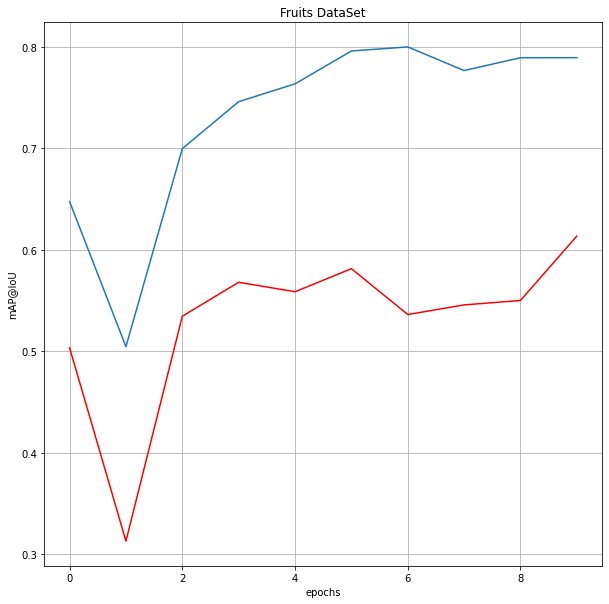

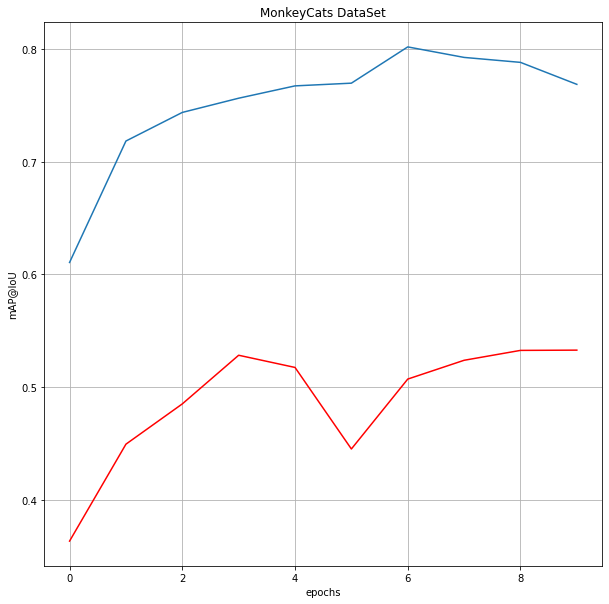

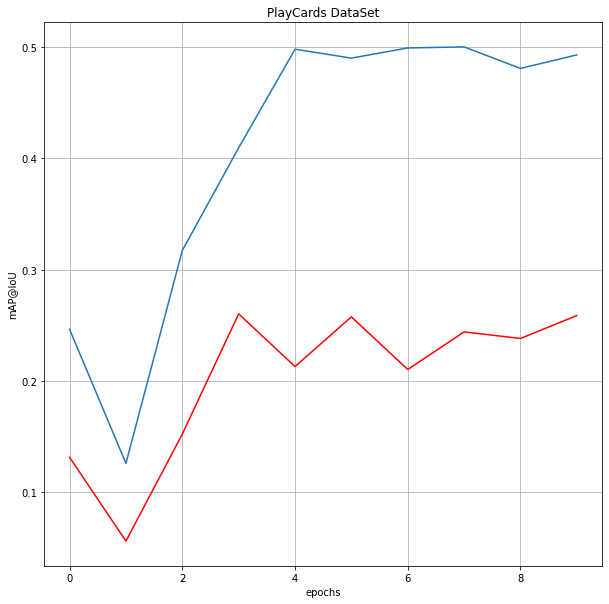

In [15]:
plotmAP("metrixs-1.txt",['Fruits DataSet',  'MonkeyCats DataSet', 'PlayCards DataSet'])

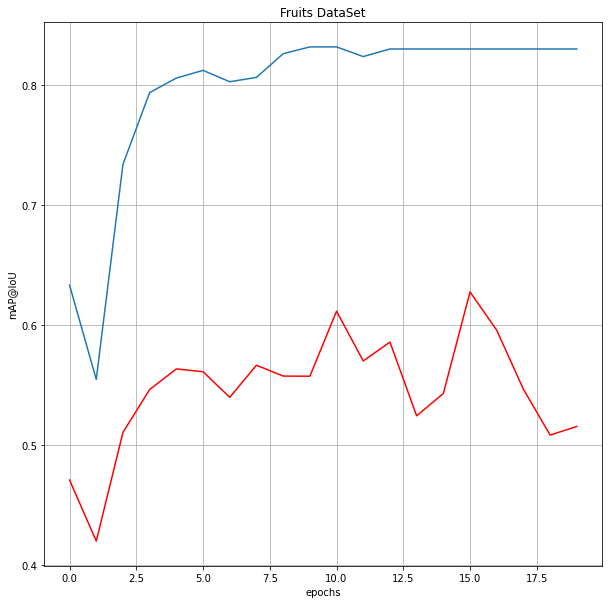

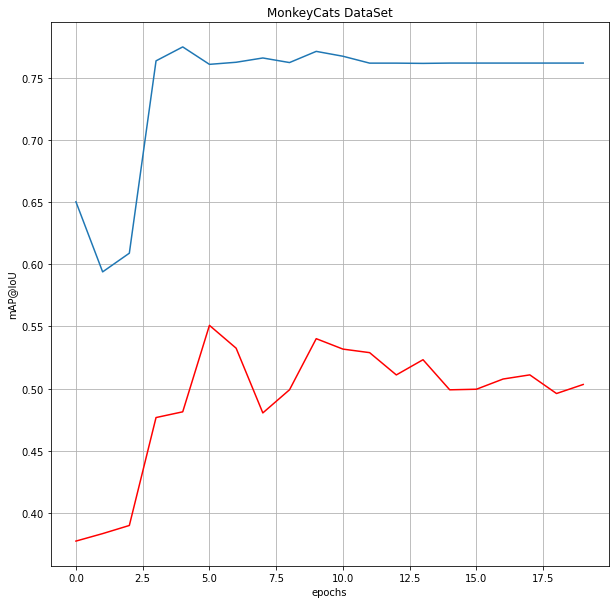

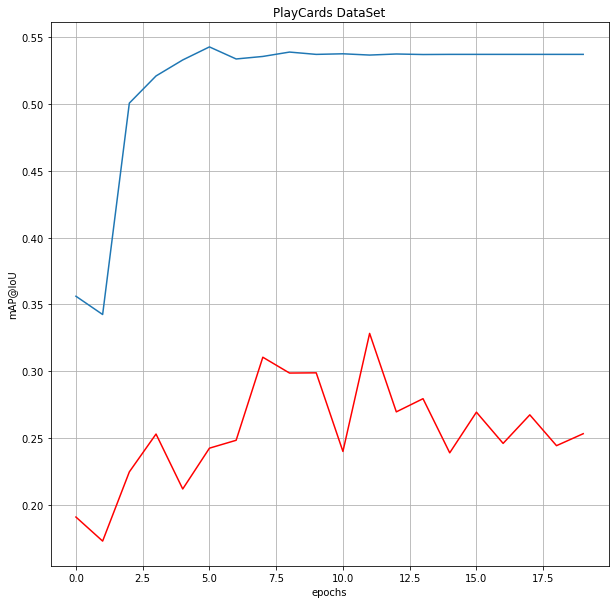

In [16]:
plotmAP("metrixs.txt",['Fruits DataSet',  'MonkeyCats DataSet', 'PlayCards DataSet'])

In [41]:
def makePrediction(num_classes,dataset,model_path,index,labels_dict):
    anchor_sizes = "16,32,64,128,256,512"
    anchor_aspect_ratios = "0.25,0.5,1.0,2.0"
    rpn_nms_threshold = 0.5
    box_nms_threshold = 0.3
    box_score_threshold = 0.1
    num_box_detections = 100
    
    #prepare model to make prediction
    model = get_model(
        num_classes,
        anchor_sizes,
        anchor_aspect_ratios,
        rpn_nms_threshold,
        box_nms_threshold,
        box_score_threshold,
        num_box_detections,
    )
    #model_path = "model_latest.pth"
    model.load_state_dict(torch.load(model_path))
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    
    # Use a random subset of the data to visualize predictions on the images.
    data_path = "./scripts"
    #dataset = BuildDataset(data_path, "Fruit" ,get_transform(train=False), train=False)
    dataset = BuildDataset(data_path, dataset ,get_transform(train=False), train=False)
    #prediction
    img, _ = dataset[index]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    preds = prediction[0]["boxes"].cpu().numpy()
    print(prediction[0]["scores"])
    print(prediction[0]['labels'])
    draw = ImageDraw.Draw(img)
    for i in range(len(preds)):
        if prediction[0]["scores"][i].item() > 0.5:
            draw.rectangle(
                ((preds[i][0], preds[i][1]), (preds[i][2], preds[i][3])), outline="red"
            )
            draw.text((preds[i][0], preds[i][1]), labels_dict[prediction[0]['labels'][i].item()], fill=(52, 55, 235,128))
    display(img)

# Porównanie z Custom Vision 

## Dataset Fruits

Po wytrenowaniu Custom Vision otrzymaliśmy takie wyniki dla datasetu Fruits: <br>
* **Precision** - jak prawdopodobne jest, że jest to prawda?
* **Recall** -  spośród tagów, które należy prawidłowo przewidzieć, jaki procent poprawnie znalazł twój model?
* **mAP** - (średnia dokładność)  ogólna wydajność detektora obiektów we wszystkich znacznikach
![](image_report/custom_fruits.png)

Przykład wykrywania objektu na zdjęciu. Jest pokazane, że to jest banan.

### Custom Vision

Zdjęcie dla Custom Vision:
![](image_report/custom_fruits_1.png)
Predition:
![](image_report/custom_fruits_2.png)

### Mask R-CNN

tensor([0.8869, 0.4075, 0.2982], device='cuda:0')
tensor([3, 1, 3], device='cuda:0')


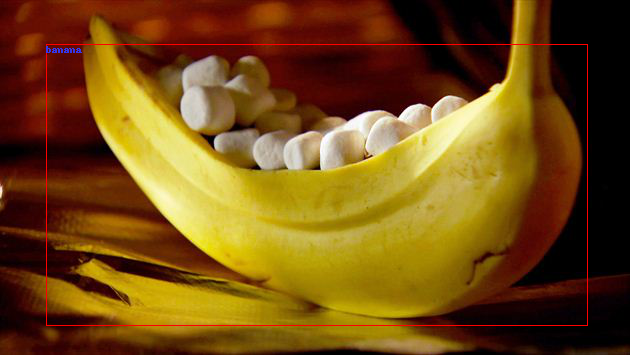

In [42]:
#Można pobawić się z predykcją
labels_dict = {1: 'apple', 2: 'orange', 3: 'banana'}
makePrediction(4,"Fruit","Fruitmodel_latest.pth",25,labels_dict)

## Dataset Monkey Cat Dog
Po wytrenowaniu Custom Vision otrzymaliśmy takie wyniki dla datasetu Monkey Cat Dog: <br>
* **Precision** - jak prawdopodobne jest, że jest to prawda?
* **Recall** -  spośród tagów, które należy prawidłowo przewidzieć, jaki procent poprawnie znalazł twój model?
* **mAP** - (średnia dokładność)  ogólna wydajność detektora obiektów we wszystkich znacznikach
![](image_report/custom_monkey)

### Custom Vision

Zdjęcie dla Custom Vision:
![](image_report/custom_monkey_1)
Predition:
![](image_report/custom_monkey_2)

### Mask R-CNN

tensor([0.9081, 0.4157], device='cuda:0')
tensor([3, 1], device='cuda:0')


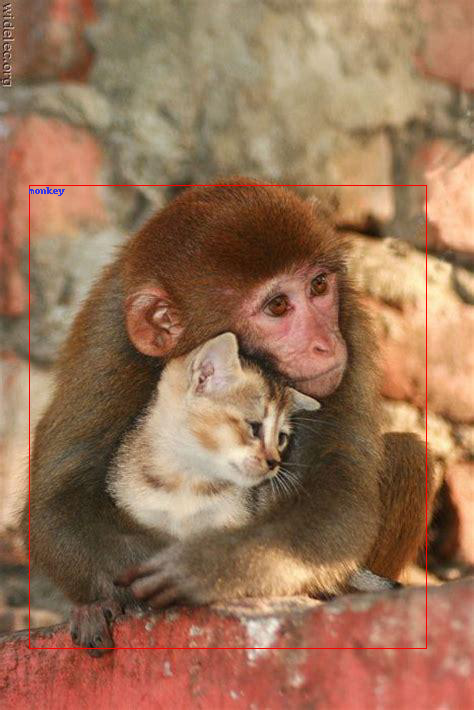

In [45]:
labels_dict = {1: "cat", 2: "dog", 3: "monkey"}
makePrediction(4,"monkeyCats","monkeyCatsmodel_latest1.pth",11,labels_dict)

### Mask R-CNN

tensor([0.8226, 0.5251, 0.1733, 0.1463], device='cuda:0')
tensor([1, 1, 5, 6], device='cuda:0')


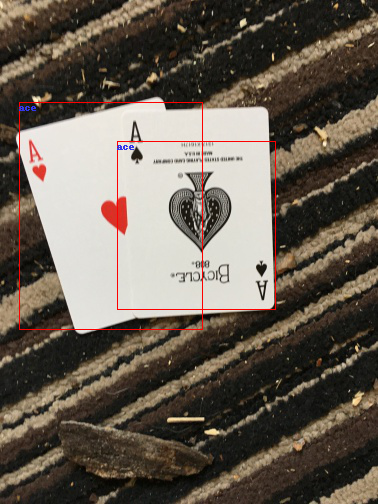

In [54]:
labels_dict = {1: 'ace', 2: 'king', 3: 'queen', 4: 'jack', 5: 'ten', 6: 'nine'}
makePrediction(7,"PlayCards","PlayCardsmodel_latest1.pth",55,labels_dict)

In [17]:
num_classes = 4
anchor_sizes = "16,32,64,128,256,512"
anchor_aspect_ratios = "0.25,0.5,1.0,2.0"
rpn_nms_threshold = 0.5
box_nms_threshold = 0.3
box_score_threshold = 0.1
num_box_detections = 100

In [24]:
# Load Mask RCNN model
model = get_model(
    num_classes,
    anchor_sizes,
    anchor_aspect_ratios,
    rpn_nms_threshold,
    box_nms_threshold,
    box_score_threshold,
    num_box_detections,
)

In [25]:
model_path = "model_latest.pth"
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [26]:
# Use a random subset of the data to visualize predictions on the images.
data_path = "./scripts"
dataset = BuildDataset(data_path, "Fruit" ,get_transform(train=False), train=False)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[-50:])

In [27]:
# for i in range(5):
#     img, _ = dataset[i]
#     model.eval()
#     with torch.no_grad():
#         prediction = model([img.to(device)])
#     img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
#     preds = prediction[0]["boxes"].cpu().numpy()
#     print(prediction[0]["scores"])
#     draw = ImageDraw.Draw(img)
#     for i in range(len(preds)):
#         draw.rectangle(
#             ((preds[i][0], preds[i][1]), (preds[i][2], preds[i][3])), outline="red"
#         )
#     display(img)

In [28]:
img, _ = dataset[1]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
preds = prediction[0]["boxes"].cpu().numpy()
print(prediction[0])

{'boxes': tensor([[  9.2525,  24.6268, 350.0000, 340.1003]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6061], device='cuda:0')}


In [29]:
labels_dict = {1: 'apple', 2: 'orange', 3: 'banana'}

#labels_dict = {1: 'ace', 2: 'king', 3: 'queen', 4: 'jack', 5: 'ten', 6: 'nine'}

#labels_dict = {1: "cat", 2: "dog", 3: "monkey"}

tensor([0.8912], device='cuda:0')
tensor([1], device='cuda:0')


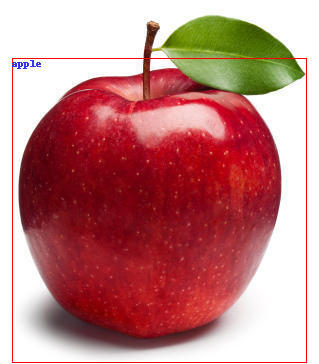

In [30]:
img, _ = dataset[12]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
preds = prediction[0]["boxes"].cpu().numpy()
print(prediction[0]["scores"])
print(prediction[0]['labels'])
draw = ImageDraw.Draw(img)
for i in range(len(preds)):
    if prediction[0]["scores"][i].item() > 0.5:
        draw.rectangle(
            ((preds[i][0], preds[i][1]), (preds[i][2], preds[i][3])), outline="red"
        )
        draw.text((preds[i][0], preds[i][1]), labels_dict[prediction[0]['labels'][i].item()], fill=(52, 55, 235,128))
display(img)

In [39]:
import xml.etree.ElementTree as ET
tree = ET.parse('scripts/Data/AnnotationsTest/cam_image45.xml') #niepoprawna sciezka
# tree = ET.parse('scripts/Data/AnnotationsTest/cats_and_monkeys_029.xml')
t_root = tree.getroot()
img = Image.open('scripts/Data/JPEGImagesTest/cam_image45.jpg')
# img = Image.open('scripts/Data/JPEGImagesTest/cats_and_monkeys_029.jpg')
draw = ImageDraw.Draw(img)
for obj in t_root.findall("object"):
    bnd_box = obj.find("bndbox")
    xmin = float(bnd_box.find("xmin").text)
    xmax = float(bnd_box.find("xmax").text)
    ymin = float(bnd_box.find("ymin").text)
    ymax = float(bnd_box.find("ymax").text)
    label_name = str(obj.find("name").text)
    draw.rectangle(
            ((xmin, ymin), (xmax, ymax)), outline="red"
        )
    draw.text((xmin, ymin), label_name, fill=(255,255,255,128))
display(img)

FileNotFoundError: [Errno 2] No such file or directory: 'scripts/Data/AnnotationsTest/cam_image45.xml'